# Run BLIP-2 with IPEX on Arc GPU

## Load image

In [1]:
from PIL import Image

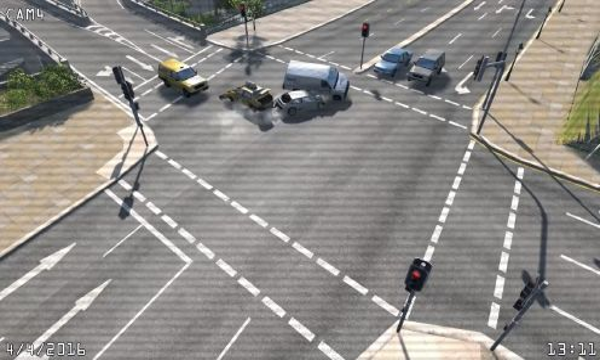

In [4]:
image = Image.open("../assets/crash.jpg").convert("RGB")
display(image.resize((600, 360)))

## Load model and processor

In [7]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch

In [2]:
from transformers import Blip2Model

In [3]:
model_id = "Salesforce/blip2-opt-2.7b"

In [ ]:
processor = AutoProcessor.from_pretrained(model_id)

In [ ]:
model = Blip2ForConditionalGeneration.from_pretrained(model_id, torch_dtype=torch.float16)

In [4]:
model = Blip2Model.from_pretrained(model_id, torch_dtype=torch.float16)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
sum(p.numel() for p in model.vision_model.parameters() if p.requires_grad)

985952256

In [10]:
sum(p.numel() for p in model.qformer.parameters() if p.requires_grad)

105137664

In [11]:
sum(p.numel() for p in model.language_model.parameters() if p.requires_grad)

2651596800

## Using IPEX

In [ ]:
import intel_extension_for_pytorch as ipex

In [ ]:
device = "xpu"

In [ ]:
model.eval()
model.to(device)
model = ipex.optimize(model)

## Image captioning

In [ ]:
inputs = processor(image, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

## Prompted image captioning

In [ ]:
prompt = "this is a picture of"

inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

In [ ]:
prompt = "the weather looks"

inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

## Visual question answering (VQA)

In [ ]:
prompt = "Question: What time of the day in this picture? Answer:"

inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=10)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

## Chat-based prompting

In [ ]:
image = Image.open("assets/merlion.png").convert("RGB")
display(image.resize((596, 437)))

In [ ]:
context = [
    ("which city is this?", "singapore"),
    ("why?", "it has a statue of a merlion"),
]
question = "where is the name merlion coming from?"
template = "Question: {} Answer: {}."

prompt = " ".join([template.format(context[i][0], context[i][1]) for i in range(len(context))]) + " Question: " + question + " Answer:"

print(prompt)

In [ ]:
inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=10)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)